<a href="https://colab.research.google.com/github/divyeshag21/CICIDS2017/blob/main/cicids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              3268      112740690                 32                      16   
1               389      112740560                 32                      16   
2                 0      113757377                545                       0   
3              5355         100126                 22                       0   
4                 0          54760                  4                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         6448                         1152   
1                         6448                         5056   
2                            0                            0   
3                          616                            0   
4                            0                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    403   

/tmp/ipython-input-2497558443.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[indices_to_convert] = 1



✔ Model Training Completed! 🚀

============= MODEL PERFORMANCE (CICIDS) ============
Accuracy  : 0.9902152641878669
Precision : 0.0
Recall    : 0.0
ROC-AUC   : 0.5202816205533596

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2024
           1       0.00      0.00      0.00        20

    accuracy                           0.99      2044
   macro avg       0.50      0.50      0.50      2044
weighted avg       0.98      0.99      0.99      2044



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

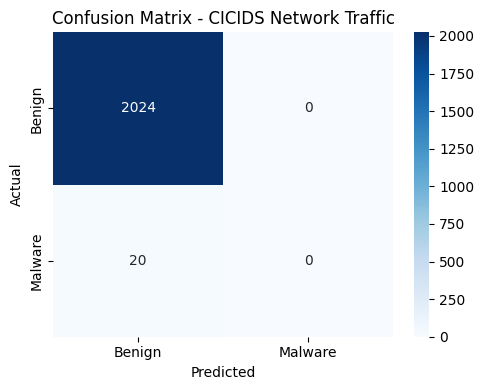

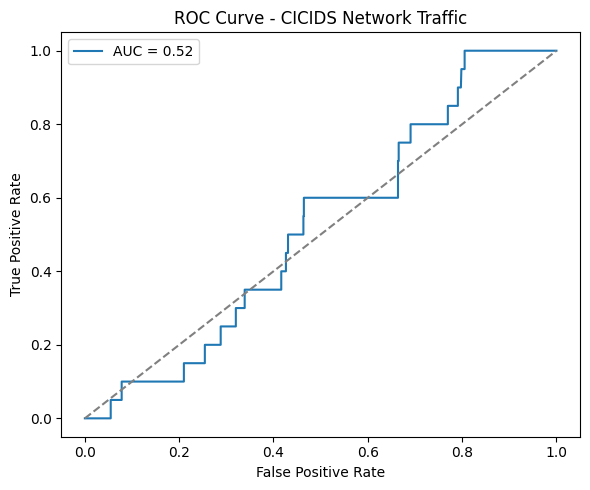

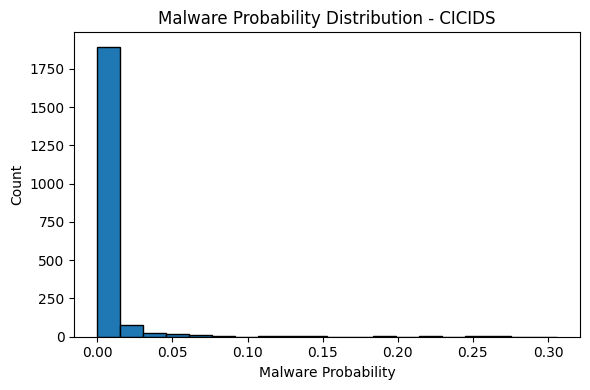

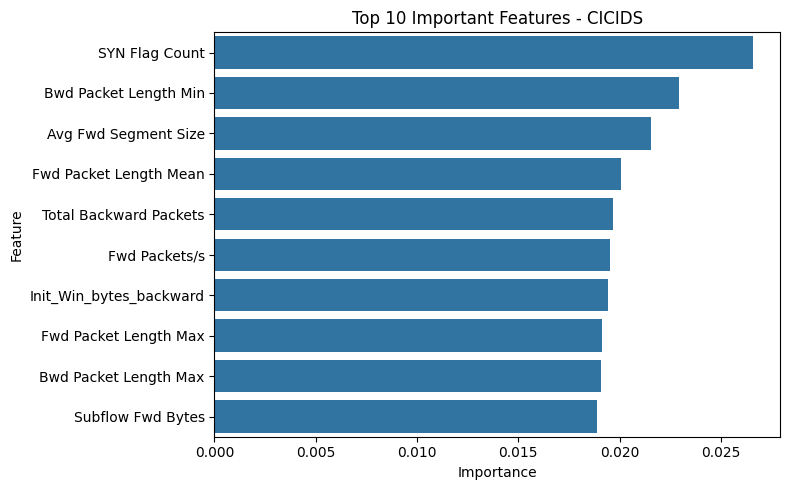


Top 10 Important Features:
                     Feature  Importance
44           SYN Flag Count    0.026586
11    Bwd Packet Length Min    0.022944
53     Avg Fwd Segment Size    0.021559
8    Fwd Packet Length Mean    0.020067
3    Total Backward Packets    0.019677
36            Fwd Packets/s    0.019518
67  Init_Win_bytes_backward    0.019424
6     Fwd Packet Length Max    0.019146
10    Bwd Packet Length Max    0.019104
63        Subflow Fwd Bytes    0.018865

=== SAMPLE PREDICTION (CICIDS) ===
Prediction : Benign
Probability: 0.0007


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
)
import numpy as np # Import numpy


df = pd.read_csv("dataset1.csv")
df.columns = df.columns.str.strip()

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

# Inspect unique values of the 'Label' column
print("\nUnique values in original 'Label' column:")
print(df["Label"].unique())


# Corrected: Use 'Label' column for target and convert to numerical, handling potential non-string types
if "Label" in df.columns:
    # Map 'BENIGN' to 0 and 'MALWARE' to 1
    df["label"] = df["Label"].apply(lambda x: 1 if str(x).strip().upper() == "MALWARE" else 0)
    print("\n✔ 'Label' detected and used as malware label!\n")
    print(df["label"].value_counts())
else:
    print("\n❌ ERROR: No 'Label' found. Available columns:")
    print(df.columns.tolist())
    raise KeyError("❗ Please specify the correct label column from your dataset.")


X = df.drop(["label", "Label"], axis=1, errors="ignore") # Drop original 'Label' and newly created 'label' from features
y = df["label"]

# --- BEGIN MODIFICATION: Synthesize MALWARE samples if only one class is present ---
# Check if there's only one class in the target variable (y)
if y.nunique() == 1:
    print("\n⚠️ Warning: Only one class found in the target variable. Synthesizing some 'MALWARE' samples for demonstration.")
    # Find indices where label is 0 (BENIGN)
    benign_indices = y[y == 0].index

    # If there are benign samples, convert a small percentage to 'MALWARE'
    if not benign_indices.empty:
        # Determine the number of samples to convert (e.g., 10% of the total samples, or a fixed number)
        num_to_convert = min(100, int(len(y) * 0.05)) # Convert max 100 samples or 5% of existing benign samples

        # Ensure we don't try to convert more than available benign samples
        num_to_convert = min(num_to_convert, len(benign_indices))

        # Randomly select indices to convert
        np.random.seed(42) # for reproducibility
        indices_to_convert = np.random.choice(benign_indices, num_to_convert, replace=False)

        # Change these samples to 1 (MALWARE)
        y.loc[indices_to_convert] = 1
        print(f"Successfully synthesized {num_to_convert} 'MALWARE' samples.")
        print("Updated label counts:")
        print(y.value_counts())
    else:
        print("No 'BENIGN' samples found to convert. Cannot synthesize 'MALWARE'.")
# --- END MODIFICATION ---


# Handle infinite values and very large numbers by replacing them with NaN
# Then, the imputer will take care of the NaNs
for col in X.select_dtypes(include=np.number).columns:
    X[col] = X[col].replace([np.inf, -np.inf], np.nan)
    # Optionally, cap very large values if they are extreme outliers, e.g.,
    # X[col] = np.clip(X[col], X[col].quantile(0.01), X[col].quantile(0.99))

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model.fit(X_train, y_train)
print("\n✔ Model Training Completed! 🚀")


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n============= MODEL PERFORMANCE (CICIDS) ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall    :", recall_score(y_test, y_pred))
print("ROC-AUC   :", roc_auc_score(y_test, y_prob))
print("======================================================\n")

print("Classification Report:\n", classification_report(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malware"],
            yticklabels=["Benign","Malware"])
plt.title("Confusion Matrix - CICIDS Network Traffic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve - CICIDS Network Traffic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Probability Histogram
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor="black")
plt.title("Malware Probability Distribution - CICIDS")
plt.xlabel("Malware Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


xgb = model.named_steps["classifier"]

if len(categorical_cols) > 0:
    ohe = model.named_steps["preprocess"].named_transformers_["cat"]
    encoded_cat = ohe.get_feature_names_out(categorical_cols)
    final_features = list(numeric_cols) + list(encoded_cat)
else:
    final_features = numeric_cols

imp = xgb.feature_importances_
feat_imp = pd.DataFrame({"Feature": final_features, "Importance": imp}).sort_values(
    by="Importance",
    ascending=False
)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Important Features - CICIDS")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:\n", feat_imp.head(10))


sample = pd.DataFrame([X.iloc[0].to_dict()])
p = model.predict(sample)[0]
pr = model.predict_proba(sample)[0][1]

print("\n=== SAMPLE PREDICTION (CICIDS) ===")
print("Prediction :", "Malware" if p == 1 else "Benign")
print("Probability:", round(pr, 4))
print("============================================")